In [39]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import beta
from scipy.special import factorial

In [40]:
INPUT_SIZE = 784
NUM_LAYERS = 2
NUM_HIDDEN_UNITS = 64
OUTPUT_SIZE = 10

NUM_EPOCHS = 10
BATCH_SIZE = 250
LEARNING_RATE = 0.1
MOMENTUM = 0.9

NUM_UNDERLYING_DISTRIBUTION = 60000

In [41]:
DATASET = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)

INDEX_UNDERLYING=list(range(NUM_UNDERLYING_DISTRIBUTION))
SUBSET_UNDERLYING=Subset(DATASET, INDEX_UNDERLYING)
LOADER_UNDERLYING=DataLoader(dataset=SUBSET_UNDERLYING, batch_size=BATCH_SIZE, shuffle=False)

In [42]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_layers-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    torch.manual_seed(1)
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [43]:
def get_bound(num_samples, eta, zeta, gamma, alpha, delta, lmbda):
    index_sample=np.random.choice(INDEX_UNDERLYING, num_samples, replace=False)
    index_other, index_approx=train_test_split(index_sample, test_size=eta)
    index_train, index_empirical_error=train_test_split(index_other, test_size=zeta)
    index_train_full, index_empirical_error_full=train_test_split(index_sample, test_size=zeta)

    num_approx=len(index_approx)
    num_empirical_error=len(index_empirical_error)
    num_empirical_error_full=len(index_empirical_error_full)
    num_train=len(index_train)
    num_train_full=len(index_train_full)
    
    subset_train=Subset(SUBSET_UNDERLYING, index_train)
    subset_train_full=Subset(SUBSET_UNDERLYING, index_train_full)
    subset_empirical_error=Subset(SUBSET_UNDERLYING, index_empirical_error)
    subset_empirical_error_full=Subset(SUBSET_UNDERLYING, index_empirical_error_full)

    loader_train = DataLoader(dataset=subset_train, batch_size=BATCH_SIZE, shuffle=True)
    loader_train_full = DataLoader(dataset=subset_train_full, batch_size=BATCH_SIZE, shuffle=True)
    loader_empirical_error = DataLoader(dataset=subset_empirical_error, batch_size=BATCH_SIZE, shuffle=False)
    loader_empirical_error_full = DataLoader(dataset=subset_empirical_error_full, batch_size=BATCH_SIZE, shuffle=False)

    model_region = NeuralNet(INPUT_SIZE, NUM_LAYERS, NUM_HIDDEN_UNITS, OUTPUT_SIZE)
    model_point = NeuralNet(INPUT_SIZE, NUM_LAYERS, NUM_HIDDEN_UNITS, OUTPUT_SIZE)
    ReLU_glorot_init(model_region)
    ReLU_glorot_init(model_point)

    criterion = nn.CrossEntropyLoss()
    optimizer_region = SGD(model_region.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    optimizer_point = SGD(model_point.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    for epoch in range(NUM_EPOCHS):
        for images, labels in loader_train:
            images = images.reshape(-1, INPUT_SIZE)
            outputs = model_region(images)
            loss = criterion(outputs, labels)
            optimizer_region.zero_grad()
            loss.backward()
            optimizer_region.step()
        #print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

    for epoch in range(NUM_EPOCHS):
        for images, labels in loader_train_full:
            images = images.reshape(-1, INPUT_SIZE)
            outputs = model_point(images)
            loss = criterion(outputs, labels)
            optimizer_point.zero_grad()
            loss.backward()
            optimizer_point.step()
        #print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

    empirical_accuracy=0
    with torch.no_grad():
        for image, label in loader_empirical_error:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_region(image)
            predictions=output.max(1)[1]
            empirical_accuracy+=sum((predictions==label).tolist())
    empirical_accuracy/=num_empirical_error

    empirical_accuracy_full=0
    with torch.no_grad():
        for image, label in loader_empirical_error_full:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_point(image)
            predictions=output.max(1)[1]
            empirical_accuracy_full+=sum((predictions==label).tolist())
    empirical_accuracy_full/=num_empirical_error_full

    true_accuracy_region=0
    correct_bools=[]
    with torch.no_grad():
        for image, label in LOADER_UNDERLYING:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_region(image)
            predictions=output.max(1)[1]
            correct_bools+=(predictions==label).tolist()
            true_accuracy_region+=sum((predictions==label).tolist())
    true_accuracy_region/=NUM_UNDERLYING_DISTRIBUTION

    true_accuracy_point=0
    with torch.no_grad():
        for image, label in LOADER_UNDERLYING:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_point(image)
            predictions=output.max(1)[1]
            true_accuracy_point+=sum((predictions==label).tolist())
    true_accuracy_point/=NUM_UNDERLYING_DISTRIBUTION

    index_verifiable=[]
    for k,correct in enumerate(correct_bools):
        if correct:
            index_verifiable.append(k)

    prop_to_sample=min(1,gamma/true_accuracy_region)
    Delta=train_test_split(index_verifiable, test_size=prop_to_sample)[1]

    p_hat=0
    for ind in index_approx:
        if ind in Delta:
            p_hat+=1
    p_hat/=num_approx
    p_L=beta.ppf(alpha,int(num_approx*p_hat),int(num_approx-num_approx*p_hat+1))

    log_component = num_empirical_error*np.log(p_L+(1-p_L)*np.exp(1/(8*num_empirical_error**2)))
    bound_region=(1-empirical_accuracy)+(log_component+np.log(1/delta))/lmbda

    bound_point=(1-empirical_accuracy_full)+lmbda/(8*num_empirical_error_full)+np.log(1/delta)/lmbda

    return 1-true_accuracy_region, 1-true_accuracy_point, bound_region, bound_point, 1-(delta+alpha*(1-delta))

In [44]:
ZETA=0.3
GAMMA=0.5
ALPHA=0.025
DELTA=0.025
LMBDA=1

SAMPLE_SIZES=[1000,5000]
ETAS=np.linspace(0.06,0.15,9)
N=len(SAMPLE_SIZES)

true_errors_region=[[] for n in range(N)]
true_errors_point=[[] for n in range(N)]
empirical_errors=[[] for n in range(N)]
bounds_region=[[] for n in range(N)]
bounds_point=[[] for n in range(N)]

for k,sample_size in enumerate(SAMPLE_SIZES):
    for eta in ETAS:
        true_error_region, true_error_point, bound_region, bound_point, con = get_bound(sample_size,eta,ZETA,GAMMA,ALPHA,DELTA,LMBDA)
        true_errors_region[k].append(true_error_region)
        true_errors_point[k].append(true_error_point)
        bounds_region[k].append(bound_region)
        bounds_point[k].append(bound_point)
        print('Sample Size {} eta {}'.format(sample_size,eta))

Sample Size 1000 eta 0.06
Sample Size 1000 eta 0.07125
Sample Size 1000 eta 0.08249999999999999
Sample Size 1000 eta 0.09375
Sample Size 1000 eta 0.105
Sample Size 1000 eta 0.11624999999999999
Sample Size 1000 eta 0.1275
Sample Size 1000 eta 0.13874999999999998
Sample Size 1000 eta 0.15
Sample Size 5000 eta 0.06
Sample Size 5000 eta 0.07125
Sample Size 5000 eta 0.08249999999999999
Sample Size 5000 eta 0.09375
Sample Size 5000 eta 0.105
Sample Size 5000 eta 0.11624999999999999
Sample Size 5000 eta 0.1275
Sample Size 5000 eta 0.13874999999999998
Sample Size 5000 eta 0.15


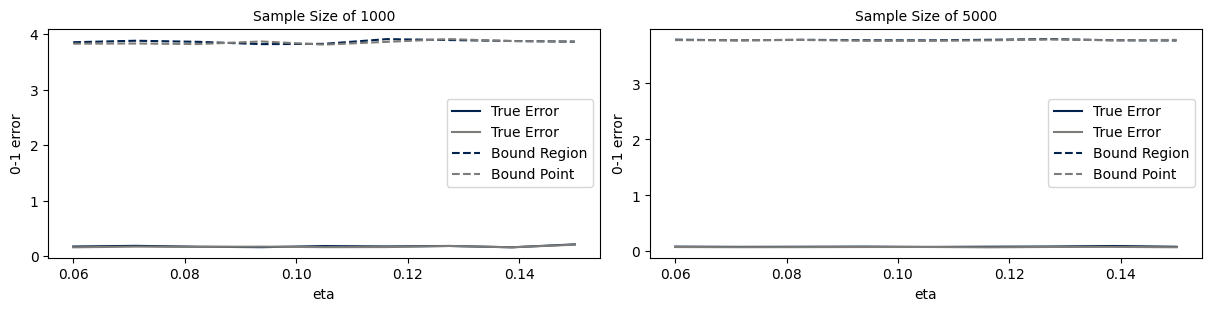

In [45]:
fig, axs = plt.subplots(1,len(SAMPLE_SIZES),figsize=(12,3),layout='constrained')
colors = plt.cm.cividis(np.linspace(0, 1, 3))
for i, ax in enumerate(axs):
    if i<N:
        ax.plot(ETAS, true_errors_region[i], label='True Error', c=colors[0])
        ax.plot(ETAS, true_errors_point[i], label='True Error', c=colors[1])
        ax.plot(ETAS, bounds_region[i], label='Bound Region', c=colors[0], linestyle='dashed')
        ax.plot(ETAS, bounds_point[i], label='Bound Point', c=colors[1], linestyle='dashed')
        ax.set_xlabel('eta')
        ax.set_ylabel('0-1 error')
        ax.set_title('Sample Size of {}'.format(SAMPLE_SIZES[i]), fontsize=10)
        ax.legend()

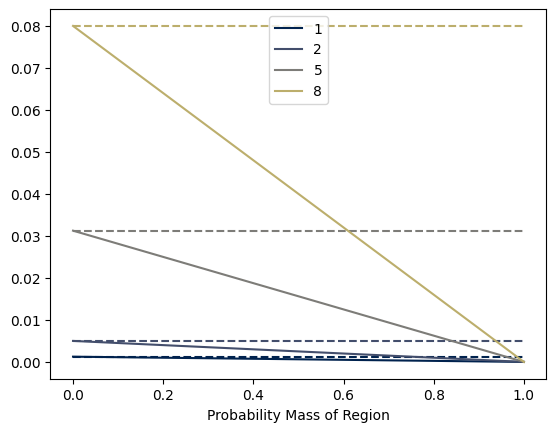

In [55]:
m=100
ps=np.linspace(0,1,100)
Cs=[1,2,5,8]
bounds_region=[[] for n in range(len(Cs))]
bounds_point=[]
for k,C in enumerate(Cs):
    for p in ps:
        bounds_region[k].append(m*np.log(p+(1-p)*np.exp(C**2/(8*m**2))))
    bounds_point.append(C**2/(8*m))
colors = plt.cm.cividis(np.linspace(0, 1, len(Cs)+1))
for k,C in enumerate(Cs):
    plt.plot(ps,bounds_region[k],color=colors[k],label=C)
    plt.plot([0,1],[bounds_point[k],bounds_point[k]],color=colors[k],linestyle='dashed')
plt.xlabel('Probability Mass of Region')
plt.legend()
plt.savefig('plots/Bayes_Bound_Performance.png')